# Hosts: Working with asset Versions

This notebook shows how to perform common versioning-related tasks using OpenAssetIO, the OpenAssetIO-MediaCreation traits, and a supporting manager.

It uses a contrived library that contains several versions of the OpenAssetIO logo.

## Setup

See "Hello OpenAssetIO" notebook for details on how to bootstrap OpenAssetIO.

In [13]:
from resources import helpers

manager, context = helpers.bootstrap("resources/querying_entity_versions/openassetio_config.toml")

## Getting started

In this example we're going to to ask the manager about other versions of the OpenAssetIO logo contained within our sample library. 

We've been given a URI by a colleague, which we need to turn into a strongly-typed `EntityReference` before we can use it to query the asset management system.

This process ensures that only known URIs are passed to any subsequent API calls. The `createEntityReference` method will throw if the input is not known to the manager. There are other forms with different failure behaviours if exceptions aren't your thing.

In [14]:
logo_ref = manager.createEntityReference("bal:///project_artwork/logos/openassetio")

helpers.display_result(repr(logo_ref))

> **Result:**
> `<openassetio.EntityReference bal:///project_artwork/logos/openassetio>`

Now we have an entity reference for our logo, we can use the API to learn more about it.

Versioning information is [not part of the core API](https://github.com/OpenAssetIO/OpenAssetIO/blob/main/doc/decisions/DR017-Entity-version-queries.md) itself. MediaCreation traits that describe how we generally work with versions in the post-production industry are used as arguments to core API methods.

## Querying an entity's version

An entity's version can be resolved using the imaginatively named `VersionTrait` from the `lifecycle` module of the `openassetio_mediacreation` package `traits`.

In [15]:
from openassetio_mediacreation.traits.lifecycle import VersionTrait
from openassetio.access import ResolveAccess

entity_data = manager.resolve(logo_ref, {VersionTrait.kId}, ResolveAccess.kRead, context)

version_trait = VersionTrait(entity_data)

The MediaCreation `VersionTrait` is used to wrap the generic `TraitsData` returned from `resolve` to provide accessors to the trait's properties. In this case - the entity's versioning information.

This trait uses the term "tag" for some string that identifies the version of an entity. Using a string, rather than a number allows full flexibility in how a specific manager may wish to handle versions and dynamic "meta-versions".

**Note: The tags themselves are specific to each manager, and are not defined by the API or the MediaCreation library. Hosts must not attempt to string munge entity references, and instead use the methods covered in this document if they wish to obtain references for specific versions. Otherwise, this defeats the function of the API as an abstraction layer.**

The `specifiedTag` property holds the version tag addressed by the entity reference.

In [16]:
helpers.display_result(version_trait.getSpecifiedTag())

> **Result:**
> `latest`

BAL uses the `v=` query param to define versions in its references. Ours did not have one (`"bal:///project_artwork/logos/openassetio"`), so BAL elects to return the latest version. Again note, this is a BAL specific behaviour, other managers may handle things differently.

The version trait defines that the `specifiedTag` property holds the tag that would behave in the same way when used in a subsequent query (see 'Querying a specific version' below). BAL set this to `"latest"`, reflecting the behaviour described above.

The version trait also has a `stableTag` property. This holds the tag for the targeted entity that is guaranteed to be free of dynamic behaviour. BAL set this to `"2"`, the tag of the latest version at the time the query was made.

In [17]:
helpers.display_result(version_trait.getStableTag())

> **Result:**
> `2`

Note that not all managers version all entities, this trait will not be imbued to the resulting data if the queried entity is un-versioned.

## Querying other versions

It was noted earlier that Hosts, generally speaking, should never "string munge" an existing entity reference to derive another one as this makes assumptions about how any manager may work. The composition of entity reference strings is certain to be unique to each manager and must not be relied upon. 

Entity references should be considered "opaque handles", and instead use the appropriate API methods to achieve the same end.

The `EntityVersionsRelationshipSpecification` from the `specifications.lifecycle` module defines a well-known relationship trait set for querying different versions of the same entity. It is used with the `getWithRelationship` method:

In [18]:
from openassetio.access import RelationsAccess

from openassetio_mediacreation.specifications.lifecycle import EntityVersionsRelationshipSpecification

# Note that the relationship query methods don't yet have the same
# convenience overloads that resolve does, and so required the use
# of the more elaborate callback signature.
related_refs = []
manager.getWithRelationship(
    [logo_ref],
    EntityVersionsRelationshipSpecification.create().traitsData(),
    10,
    RelationsAccess.kRead, 
    context, 
    lambda _, pager: related_refs.extend(pager.get()), lambda _, err: print(err.message))

helpers.display_result(related_refs)

> **Result:**
> - `bal:///project_artwork/logos/openassetio`
> - `bal:///project_artwork/logos/openassetio?v=2`
> - `bal:///project_artwork/logos/openassetio?v=1`

We now have the references for all versions of the logo. The `EntityVersionsRelationshipSpecification` allows the inclusion of dynamic "meta-versions", and so you can see the BAL has provided references for both the "latest" and stable variations of the entity references. Some asset management systems may have a whole host of dynamic references to cover concepts such as approval and other workflow related statuses.

The `EntityVersionsRelationshipSpecification` also defines that versions will be ordered with the most relevant first. This is usually reverse chronological order.

## Querying stable versions

While powerful, dynamic versioning behaviour can be error-prone in some situations. MediaCreation also provides a specialisation of the entity versions relationship that only provides stable references - `StableEntityVersionsRelationshipSpecification` - for situations where you need to guarantee that a referenced entity will not change over time.

For the curious, this extends `EntityVersionsRelationshipSpecification` with one additional trait - the `StableTrait`.

If we use this, BAL will now only give us references that point to concrete versions of the logo:

In [19]:
from openassetio.access import RelationsAccess

from openassetio_mediacreation.specifications.lifecycle import StableEntityVersionsRelationshipSpecification

# Note that the relationship query methods don't yet have the same
# convenience overloads that resolve does, and so required the use
# of the more elaborate callback signature.
versions_refs = []
manager.getWithRelationship(
    [logo_ref], 
    StableEntityVersionsRelationshipSpecification.create().traitsData(), 
    10,
    RelationsAccess.kRead, 
    context, 
    lambda _, pager: versions_refs.extend(pager.get()), lambda _, err: print(err.message))

helpers.display_result(versions_refs)

> **Result:**
> - `bal:///project_artwork/logos/openassetio?v=2`
> - `bal:///project_artwork/logos/openassetio?v=1`

Now we have these references, lets take a look at how the logo has evolved:

The OpenAssetIO logo (Version '2')


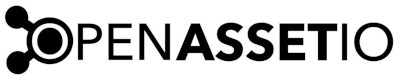

The OpenAssetIO logo (Version '1')


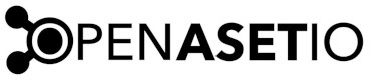

In [20]:
from openassetio.access import ResolveAccess
from openassetio_mediacreation.traits.content import LocatableContentTrait
from openassetio_mediacreation.traits.identity import DisplayNameTrait
from openassetio_mediacreation.traits.lifecycle import VersionTrait

# We can re-use the list of references to batch-resolve several traits for 
# all versions at once. This can be useful for building menus/pickers/etc...
# Batching helps mitigate the cost of expensive database lookups that incur
# a fixed per-call cost due to network latency
all_versions_entity_data = manager.resolve(
    versions_refs, 
    {LocatableContentTrait.kId, DisplayNameTrait.kId, VersionTrait.kId}, 
    ResolveAccess.kRead, context)

# Display some rudimentary information about each version
for entity_data in all_versions_entity_data:
    name = DisplayNameTrait(entity_data).getName()
    version_tag = VersionTrait(entity_data).getStableTag()
    print(f"{name} (Version '{version_tag}')")
    helpers.display_image(LocatableContentTrait(entity_data).getLocation())

## Querying a specific version

We can also set trait properties when we make a relationship query, and this will act as a filter. we're going to use the `getWithRelationship` method with the unversioned entity reference, to query the reference for a specific version of the entity - v1 - using a specific version tag (perhaps entered by the user or previously obtained from the `VersionTrait`).

In [21]:
from openassetio.access import RelationsAccess

from openassetio_mediacreation.specifications.lifecycle import EntityVersionsRelationshipSpecification

# Define the relationship we wish to query, and the specific
# tag we want to look up (using data from a previous API call
# or specified by the end-user).
relationship_spec = EntityVersionsRelationshipSpecification.create()
relationship_spec.versionTrait().setSpecifiedTag("1")

# Note that the relationship query methods don't yet have the same
# convenience overloads that resolve does, and so required the use
# of the more elaborate callback signature.
related_refs = []
manager.getWithRelationship(
    [logo_ref], 
    relationship_spec.traitsData(), 
    10,
    RelationsAccess.kRead, 
    context, 
    lambda _, pager: related_refs.extend(pager.get()), lambda _, err: print(err.message))

helpers.display_result(related_refs)

> **Result:**
> - `bal:///project_artwork/logos/openassetio?v=1`

We now have a reference to the specific version, without needing to know anything about how the managers entity references are formatted.

## Obtaining a stable reference

As we saw earlier, some asset management systems may make use of dynamic behaviour, such as a "latest" version. If you desire to persist an entity reference as it stands at any given point in time, you can query the `StableReferenceRelationshipSpecification`from the `specifications.lifecycle` module. This only ever returns a single entity reference, that is guaranteed to be free from any dynamic behaviour. This can be useful if you need to persist a reference and guarantee the referenced entity won't change over time.

In [22]:
from openassetio.access import RelationsAccess

from openassetio_mediacreation.specifications.lifecycle import StableReferenceRelationshipSpecification

# Note that the relationship query methods don't yet have the same
# convenience overloads that resolve does, and so required the use
# of the more elaborate callback signature.
stable_refs = []
manager.getWithRelationship(
    [logo_ref], 
    StableReferenceRelationshipSpecification.create().traitsData(),
    10,
    RelationsAccess.kRead, 
    context, 
    lambda _, pager: stable_refs.extend(pager.get()), lambda _, err: print(err.message))

helpers.display_result(stable_refs)

> **Result:**
> - `bal:///project_artwork/logos/openassetio?v=2`